# Training a Flow Matching Model for 2D Point Generation

In this tutorial, you'll learn how to train a flow matching model to generate spirals of 2-D points.

We'll explore the different components of flow matching models and their functions, as well as compare the quality of generated results using different model architectures.

## What you'll learn
- How flow matching works conceptually
- Three different model architectures for implementing flow matching
- How to visualize and evaluate the generated results
- Best practices for training flow matching models

## Prerequisites
- Basic understanding of PyTorch
- Familiarity with neural networks and optimization


In [2]:
from dataclasses import dataclass
import math
from typing import Dict, Tuple

from matplotlib import pyplot as plt
from sklearn.datasets import make_swiss_roll
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchdyn.core import NeuralODE

# The Data

First, let's take a look at the data we'll be working with. Diffusion models can be very resource intensive when trained on images and videos, so in order for us to train on a CPU quickly, we'll start off by using a dataset of spirals in 2 dimensions.

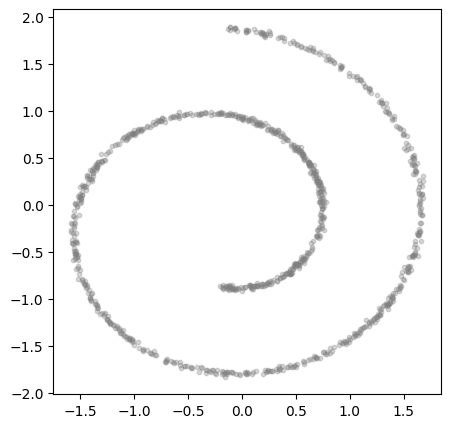

In [3]:
x, _ = make_swiss_roll(n_samples=1000, noise=0.1)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()
plt.figure(figsize=(5, 5))
_ = plt.scatter(x[:, 0], x[:, 1], s=10, alpha=0.3, color="Gray")
# _ = plt.axis("off")

## Dataloaders

Before training the model, we need to define some hyperparameters and create our train and validation dataloaders.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class TrainingConfig:
    batch_size: int = 256 # batch size
    learning_rate: float = 5e-4 # initial learning rate
    weight_decay: float = 1e-6 # weight decay
    num_denoising_steps: int = 1000 # number of timesteps


def load_data(config: TrainingConfig) -> Tuple[DataLoader, DataLoader]:
    """
    Load the data and return the train and validation dataloaders.

    Args:
      config: TrainingConfig object.
    Returns:
      train_dataloader: DataLoader for the training data.
      val_dataloader: DataLoader for the validation data.
    """
    n = int(1e+6)
    x, _ = make_swiss_roll(n_samples=n, noise=0)
    x = x[:, [0, 2]]
    scaling = 2
    x = (x - x.mean()) / x.std() * scaling
    x_train = x[:int(n * 0.8), :]
    x_val = x[int(n * 0.8):, :]

    class SimpleDataset:
      def __init__(self, data):
        self.data = data

      def __len__(self):
        return len(self.data)

      def __getitem__(self, i):
        return self.data[i]

    train_dataset = SimpleDataset(x_train)
    val_dataset = SimpleDataset(x_val)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader


config = TrainingConfig()
train_dataloader, val_dataloader = load_data(config)
first_batch = next(iter(train_dataloader))
print("batch shape:", first_batch.shape)

batch shape: torch.Size([256, 2])


# Helper Functions

In [5]:
def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    Example
    -------
    x: Tensor (bs, C, W, H)
    t: Vector (bs)
    pad_t_like_x(t, x): Tensor (bs, 1, 1, 1)
    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))

# The Models

Now it's time to define the models. We will define three separate models for the sake of comparison, where the difference between them is in how the information about the current timestep is integrated into the model's architecture.

1. Time Embedding Concatination
2. Sinusoidal Time Embedding Concatination
3. Sinusoidal Time Embedding Muliplication

### Model 1: Timestep Concatination 

Our first model is a simple three layer MLP. Note that in the `foward` method, we concatinate the time to the input before each foward pass. This allows the model to have a sense of the where it is in the denoising process.

In [6]:
class Model1(nn.Module):
  def __init__(self, hidden_dim=512):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(3, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, 2),
      nn.Tanh(),
    )

  def forward(self, t, x, **kwargs):
    t = t / 1000.
    # print("t:", t.shape, "x:", x.shape)
    t = t.reshape(-1, 1)
    # make sure t is the same shape as x
    t = t.expand(*x.shape[:-1], -1)
    return self.net(torch.cat([t, x], 1))

model1 = Model1().to(device)
print(f"model params: {sum(p.numel() for p in model1.parameters())}")

model params: 265730


### Model 2: Sinusoidal Time Embedding Concatination

In this model, we utilize a 3-layer MLP. Instead of concatenating the raw time embedding directly to the image embedding, we first transform the time embedding into a sinusoidal embedding and then concatenate it with the image embedding.

**History**

This model builds upon the idea of incorporating temporal information into the embedding space, inspired by the effectiveness of sinusoidal embeddings in positional encoding for transformers. The sinusoidal representation allows the model to capture periodicity and smooth transitions in the time domain, potentially improving its ability to generalize across different temporal contexts.

In [7]:
class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features = [64, 64],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])


class Model2(nn.Module):
    def __init__(self, features: int, freqs: int = 16, **kwargs):
        super().__init__()

        self.net = MLP(2 * freqs + features, features, **kwargs)

        self.register_buffer('freqs', torch.arange(1, freqs + 1) * torch.pi)

    def forward(self, t, x, **kwargs):
        t = t / 1000.
        t = self.freqs * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)

        return self.net(torch.cat((t, x), dim=-1))


model2 = Model2(features=2, hidden_features=[256, 256, 512]).to(device)
print(f"model params: {sum(p.numel() for p in model2.parameters())}")

model params: 207362


### Model 3: Sinusoidal Time Embeddings Multiplication

Model 3 introduces a time-conditioned architecture where time is incorporated directly into the network through TimeLinear layers. Instead of directly concatenating time embeddings with the image embeddings, the model uses the time embeddings to modulate the weights of the linear transformations dynamically. This approach allows the network to adapt its behavior to different timesteps, enabling more nuanced temporal modeling. 

In [8]:
class TimeEmbedding(nn.Module):
    """
    Time embedding module that embeds the time step into a hidden representation.
    Args:
        hidden_size: the size of the hidden representation.
        frequency_embedding_size: the size of the frequency embedding
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor, **kwargs):
        """Forward pass of the module."""

        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class TimeLinear(nn.Module):
    """
    Time linear layer that applies a linear transformation with time-dependent weights.
    """

    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        """
        Args:
            dim_in: the number of input features.
            dim_out: the number of output features.
            num_timesteps: the number of timesteps.
        """
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)
        return alpha * x


class Model3(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: list[int], num_timesteps: int
    ):
        super().__init__()
        """
        Build a noise estimating network.

        Args:
            dim_in: dimension of input
            dim_out: dimension of output
            dim_hids: dimensions of hidden features
            num_timesteps: number of timesteps
        """

        layers = []
        dims = [dim_in] + dim_hids

        # Build MLP layers with time-dependent linear layers
        for i in range(len(dims)-1):
            layers.append(TimeLinear(dims[i], dims[i+1], num_timesteps))
            layers.append(nn.ReLU())

        # Final layer to output noise prediction
        layers.append(TimeLinear(dims[-1], dim_out, num_timesteps))

        self.net = nn.Sequential(*layers)
        self.num_timesteps = num_timesteps


    def forward(self, t: torch.Tensor, x: torch.Tensor, **kwargs):
        """
        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        for layer in self.net:
            if isinstance(layer, TimeLinear):
                x = layer(x, t)
            else:
                x = layer(x)
        ######################
        return x


model3 = Model3(
    dim_in=2,
    dim_out=2,
    dim_hids=[128, 128, 128, 128],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

model params: 248330


# FLow Plan

Here we create a flow matching plan. It includes the "forward" and "backward" processes.

## Conditional Flow Matcher

In [9]:
from typing import Union


class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods. This class implements the independent
    conditional flow matching methods from [1] and serves as a parent class for all other flow
    matching methods.

    It implements:
    - Drawing data from gaussian probability path N(t * x1 + (1 - t) * x0, sigma) function
    - conditional flow matching ut(x1|x0) = x1 - x0
    - score function $\nabla log p_t(x|x0, x1)$
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        """
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        """
        Compute the mean of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)

        Returns
        -------
        mean mu_t: t * x1 + (1 - t) * x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        t = pad_t_like_x(t, x0)
        return t * x1 + (1 - t) * x0

    def compute_sigma_t(self, t):
        """
        Compute the standard deviation of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        standard deviation sigma

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t
        return self.sigma

    def sample_xt(self, x0, x1, t, epsilon):
        """
        Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        epsilon : Tensor, shape (bs, *dim)
            noise sample from N(0, 1)

        Returns
        -------
        xt : Tensor, shape (bs, *dim)

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + sigma_t * epsilon

    def compute_conditional_flow(self, x0, x1, t, xt):
        """
        Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt

        Returns
        -------
        ut : conditional vector field ut(x1|x0) = x1 - x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t, xt
        return x1 - x0

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) eps: Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], f"t has to have batch size dimension, got {len(t)}"

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

    def compute_lambda(self, t):
        """Compute the lambda function, see Eq.(23) [3].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        lambda : score weighting function

        References
        ----------
        [4] Simulation-free Schrodinger bridges via score and flow matching, Preprint, Tong et al.
        """
        sigma_t = self.compute_sigma_t(t)
        return 2 * sigma_t / (self.sigma**2 + 1e-8)



In [10]:
import numpy as np
import ot as pot
import warnings
from functools import partial

class OTPlanSampler:
    """OTPlanSampler implements sampling coordinates according to an OT plan (wrt squared Euclidean
    cost) with different implementations of the plan calculation."""

    def __init__(
        self,
        method: str,
        reg: float = 0.05,
        reg_m: float = 1.0,
        normalize_cost: bool = False,
        num_threads: Union[int, str] = 1,
        warn: bool = True,
    ) -> None:
        """Initialize the OTPlanSampler class.

        Parameters
        ----------
        method: str
            choose which optimal transport solver you would like to use.
            Currently supported are ["exact", "sinkhorn", "unbalanced",
            "partial"] OT solvers.
        reg: float, optional
            regularization parameter to use for Sinkhorn-based iterative solvers.
        reg_m: float, optional
            regularization weight for unbalanced Sinkhorn-knopp solver.
        normalize_cost: bool, optional
            normalizes the cost matrix so that the maximum cost is 1. Helps
            stabilize Sinkhorn-based solvers. Should not be used in the vast
            majority of cases.
        num_threads: int or str, optional
            number of threads to use for the "exact" OT solver. If "max", uses
            the maximum number of threads.
        warn: bool, optional
            if True, raises a warning if the algorithm does not converge
        """
        # ot_fn should take (a, b, M) as arguments where a, b are marginals and
        # M is a cost matrix
        if method == "exact":
            self.ot_fn = partial(pot.emd, numThreads=num_threads)
        elif method == "sinkhorn":
            self.ot_fn = partial(pot.sinkhorn, reg=reg)
        elif method == "unbalanced":
            self.ot_fn = partial(pot.unbalanced.sinkhorn_knopp_unbalanced, reg=reg, reg_m=reg_m)
        elif method == "partial":
            self.ot_fn = partial(pot.partial.entropic_partial_wasserstein, reg=reg)
        else:
            raise ValueError(f"Unknown method: {method}")
        self.reg = reg
        self.reg_m = reg_m
        self.normalize_cost = normalize_cost
        self.warn = warn

    def get_map(self, x0, x1):
        """Compute the OT plan (wrt squared Euclidean cost) between a source and a target
        minibatch.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch

        Returns
        -------
        p : numpy array, shape (bs, bs)
            represents the OT plan between minibatches
        """
        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        if x0.dim() > 2:
            x0 = x0.reshape(x0.shape[0], -1)
        if x1.dim() > 2:
            x1 = x1.reshape(x1.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        if self.normalize_cost:
            M = M / M.max()  # should not be normalized when using minibatches
        p = self.ot_fn(a, b, M.detach().cpu().numpy())
        if not np.all(np.isfinite(p)):
            print("ERROR: p is not finite")
            print(p)
            print("Cost mean, max", M.mean(), M.max())
            print(x0, x1)
        if np.abs(p.sum()) < 1e-8:
            if self.warn:
                warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")
            p = np.ones_like(p) / p.size
        return p

    def sample_map(self, pi, batch_size, replace=True):
        r"""Draw source and target samples from pi  $(x,z) \sim \pi$

        Parameters
        ----------
        pi : numpy array, shape (bs, bs)
            represents the source minibatch
        batch_size : int
            represents the OT plan between minibatches
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        (i_s, i_j) : tuple of numpy arrays, shape (bs, bs)
            represents the indices of source and target data samples from $\pi$
        """
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=replace
        )
        return np.divmod(choices, pi.shape[1])

    def sample_plan(self, x0, x1, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return x0[i], x1[j]

    def sample_plan_with_labels(self, x0, x1, y0=None, y1=None, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target labeled samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs)
            represents the source label minibatch
        y1 : Tensor, shape (bs)
            represents the target label minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the target minibatch drawn from $\pi$
        y0[i] : Tensor, shape (bs, *dim)
            represents the source label minibatch drawn from $\pi$
        y1[j] : Tensor, shape (bs, *dim)
            represents the target label minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return (
            x0[i],
            x1[j],
            y0[i] if y0 is not None else None,
            y1[j] if y1 is not None else None,
        )

    def sample_trajectory(self, X):
        """Compute the OT trajectories between different sample populations moving from the source
        to the target distribution.

        Parameters
        ----------
        X : Tensor, (bs, times, *dim)
            different populations of samples moving from the source to the target distribution.

        Returns
        -------
        to_return : Tensor, (bs, times, *dim)
            represents the OT sampled trajectories over time.
        """
        times = X.shape[1]
        pis = []
        for t in range(times - 1):
            pis.append(self.get_map(X[:, t], X[:, t + 1]))

        indices = [np.arange(X.shape[0])]
        for pi in pis:
            j = []
            for i in indices[-1]:
                j.append(np.random.choice(pi.shape[1], p=pi[i] / pi[i].sum()))
            indices.append(np.array(j))

        to_return = []
        for t in range(times):
            to_return.append(X[:, t][indices[t]])
        to_return = np.stack(to_return, axis=1)
        return to_return


class ExactOptimalTransportConditionalFlowMatcher(ConditionalFlowMatcher):
    """Child class for optimal transport conditional flow matching method. This class implements
    the OT-CFM methods from [1] and inherits the ConditionalFlowMatcher parent class.

    It overrides the sample_location_and_conditional_flow.
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        ot_sampler: exact OT method to draw couplings (x0, x1) (see Eq.(17) [1]).
        """
        super().__init__(sigma)
        self.ot_sampler = OTPlanSampler(method="exact")

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        r"""
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
        with respect to the minibatch OT plan $\Pi$.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon

        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        x0, x1 = self.ot_sampler.sample_plan(x0, x1)
        return super().sample_location_and_conditional_flow(x0, x1, t, return_noise)

    def guided_sample_location_and_conditional_flow(
        self, x0, x1, y0=None, y1=None, t=None, return_noise=False
    ):
        r"""
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
        with respect to the minibatch OT plan $\Pi$.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs) (default: None)
            represents the source label minibatch
        y1 : Tensor, shape (bs) (default: None)
            represents the target label minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon

        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        x0, x1, y0, y1 = self.ot_sampler.sample_plan_with_labels(x0, x1, y0, y1)
        if return_noise:
            t, xt, ut, eps = super().sample_location_and_conditional_flow(x0, x1, t, return_noise)
            return t, xt, ut, y0, y1, eps
        else:
            t, xt, ut = super().sample_location_and_conditional_flow(x0, x1, t, return_noise)
            return t, xt, ut, y0, y1


2024-12-04 18:52:30.772561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 18:52:30.784219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 18:52:30.796454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 18:52:30.800108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 18:52:30.811254: I tensorflow/core/platform/cpu_feature_guar

In [11]:
def generate_samples_with_flow_matching(
        denoising_model, device, num_samples: int = 8,
        data_dims = [2,], parallel: bool = False, seed: int = 0,
        clip_min: float = -1.0, clip_max: float = 1.0,
        num_timesteps: int = 100,
    ):
    """Generate samples.

    Parameters
    ----------
    model:
        represents the neural network that we want to generate samples from
    parallel: bool
        represents the parallel training flag. Torchdyn only runs on 1 GPU, we need to send the models from several GPUs to 1 GPU.
    savedir: str
        represents the path where we want to save the generated images
    step: int
        represents the current step of training
    """
    model = denoising_model
    
    
    if parallel:
        import copy
        model = copy.deepcopy(denoising_model)
        # Send the models from GPU to CPU for inference with NeuralODE from Torchdyn
        model = model.to(device)

    with torch.no_grad():
        torch.manual_seed(seed)
        node = NeuralODE(model, solver="euler", sensitivity="adjoint")
        
        with torch.no_grad():
            traj = node.trajectory(
                torch.randn(num_samples, *data_dims, device=device),
                t_span=torch.linspace(0, 1, num_timesteps, device=device),
            )
            traj = traj[-1, :].view([-1, *data_dims]).clip(clip_min, clip_max)
            # traj = traj / 2 + 0.5
    
    return traj  # range is expected to be [0, 1]?


In [12]:
FM = ConditionalFlowMatcher(sigma=0)
# FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0)

### How does flow matching plan the route?

In [13]:
torch.linspace(0, 1, 10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

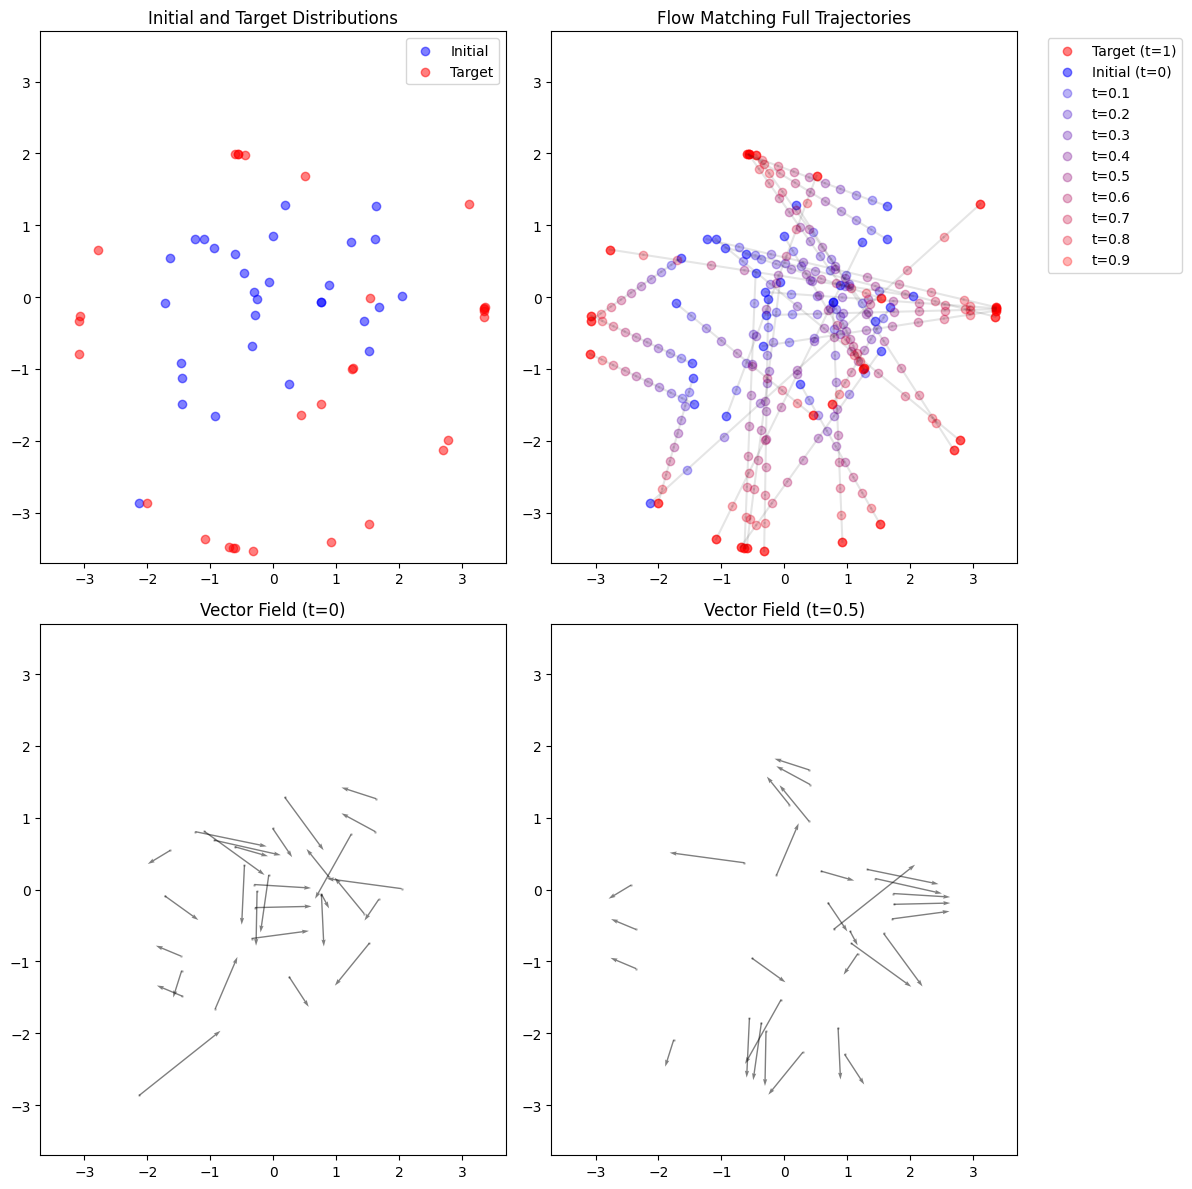

In [14]:
def plot_flow_matching_trajectories(FM, n_examples=30):
    # set a commmon xlim and ylim
    xlim = [-3.7, 3.7]
    ylim = [-3.7, 3.7]
    # clean data (spiral)
    x_clean = next(iter(val_dataloader))[:n_examples]

    # noisy data
    x_noisy = torch.randn_like(x_clean)

    # Sample multiple timesteps to visualize flow progression
    num_timesteps = 10
    t_grid = torch.linspace(0, 1, num_timesteps)
    x_ts = []
    u_ts = []

    for t in t_grid:
        t_batch = t.repeat(x_clean.shape[0])
        np.random.seed(0)
        t, x_t, u_t = FM.sample_location_and_conditional_flow(x0=x_noisy, x1=x_clean, t=t_batch)
        x_ts.append(x_t.detach().cpu().numpy())
        u_ts.append(u_t.detach().cpu().numpy())

    # Create visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Plot initial and final distributions
    axs[0, 0].scatter(x_noisy[:, 0], x_noisy[:, 1], color='blue', alpha=0.5, label='Initial')
    axs[0, 0].scatter(x_clean[:, 0], x_clean[:, 1], color='red', alpha=0.5, label='Target') 
    axs[0, 0].set_title("Initial and Target Distributions")
    axs[0, 0].legend()
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)

    # ======================================
    ## Now show the full trajectories
    # ======================================
    axs[0, 1].scatter(x_ts[-1][:, 0], x_ts[-1][:, 1], color='red', alpha=0.5, label='Target (t=1)')
    axs[0, 1].scatter(x_ts[0][:, 0], x_ts[0][:, 1], color='blue', alpha=0.5, label='Initial (t=0)')
    
    # Sample a few timesteps to show progression
    sample_ts = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    for t in sample_ts:
        current_points = np.array(x_ts[t])
        prev_points = np.array(x_ts[t-1])
        # Calculate color interpolation factor (0 to 1)
        factor = t / (len(x_ts)-1)
        # Interpolate between blue (0,0,1) and red (1,0,0)
        color = (factor, 0, 1-factor)
        axs[0, 1].scatter(current_points[:, 0], current_points[:, 1], color=color, alpha=0.3, label=f't=0.{t}')
        # connect the dots: previous point to current point
        assert prev_points.shape == (n_examples, 2), f"prev_traj.shape={prev_points.shape}"
        
        for i_point in range(len(current_points)):
            # Plot the line segment from previous point to current point
            axs[0, 1].plot(
                [prev_points[i_point, 0], current_points[i_point, 0]],
                [prev_points[i_point, 1], current_points[i_point, 1]],
                'k-', alpha=0.1
            )
    
    axs[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[0, 1].set_title("Flow Matching Full Trajectories")
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)

    # Plot vector field at t=0
    x_0 = x_ts[0]
    u_0 = u_ts[0]
    axs[1, 0].quiver(x_0[:, 0], x_0[:, 1], u_0[:, 0], u_0[:, 1], 
                alpha=0.5, scale=30, width=0.003)
    axs[1, 0].scatter(x_0[:, 0], x_0[:, 1], c='k', alpha=0.2, s=1)
    axs[1, 0].set_title("Vector Field (t=0)")
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)

    # Plot vector field at t=0.5
    mid_idx = len(x_ts)//2
    x_mid = x_ts[mid_idx]
    u_mid = u_ts[mid_idx]
    axs[1, 1].quiver(x_mid[:, 0], x_mid[:, 1], u_mid[:, 0], u_mid[:, 1], 
                alpha=0.5, scale=30, width=0.003)
    axs[1, 1].scatter(x_mid[:, 0], x_mid[:, 1], c='k', alpha=0.2, s=1)
    axs[1, 1].set_title("Vector Field (t=0.5)")
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)

    plt.tight_layout()


plot_flow_matching_trajectories(FM, n_examples=30)


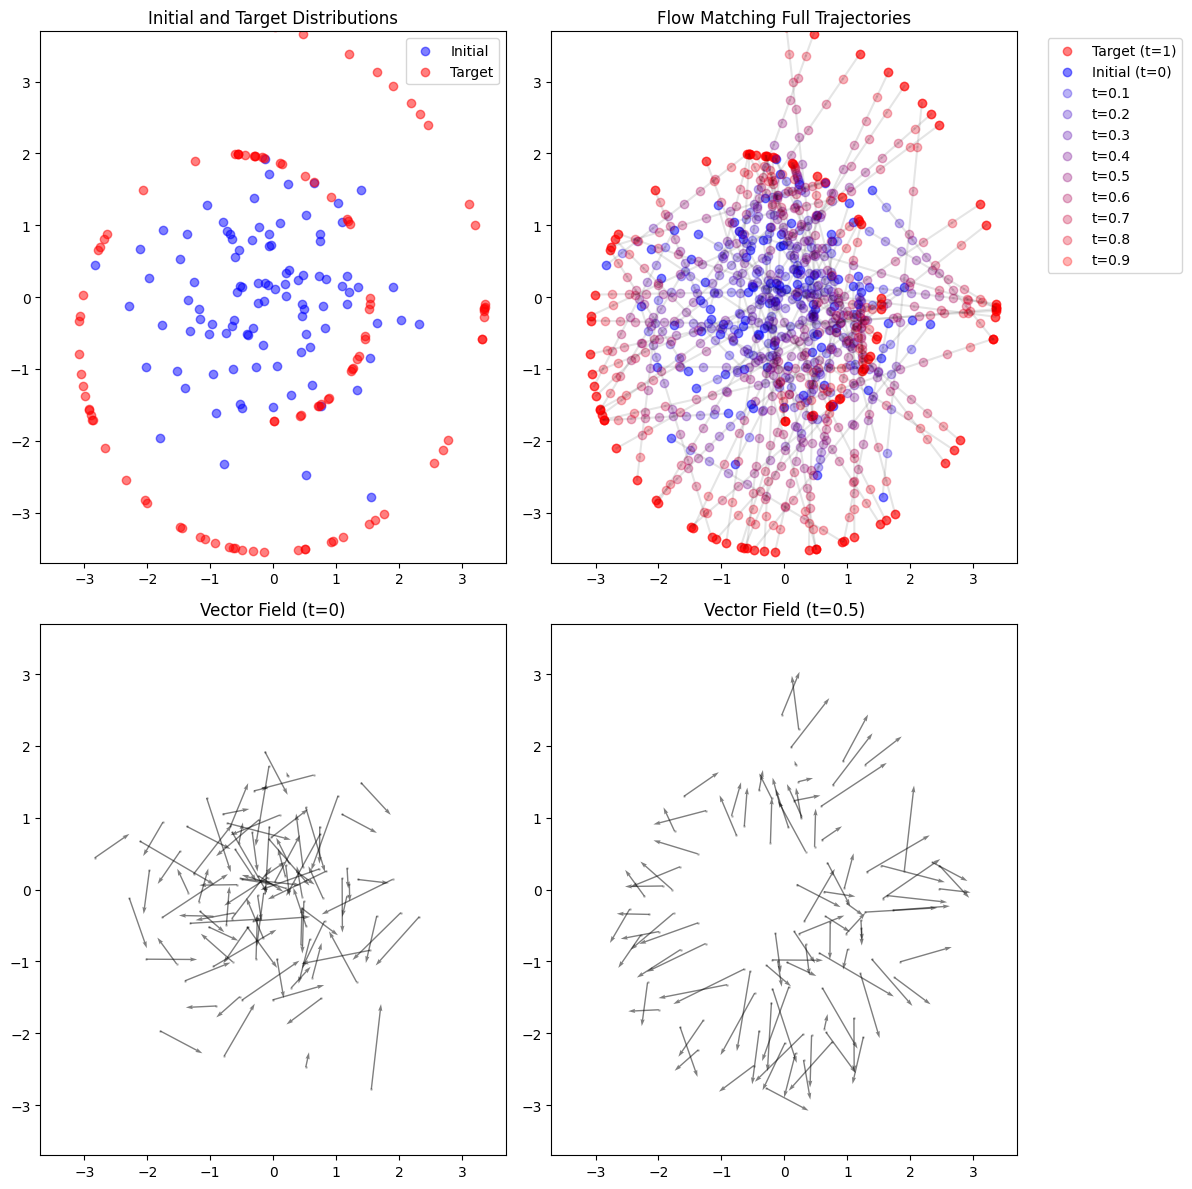

In [15]:
# Drawing more samples
plot_flow_matching_trajectories(FM, n_examples=100)

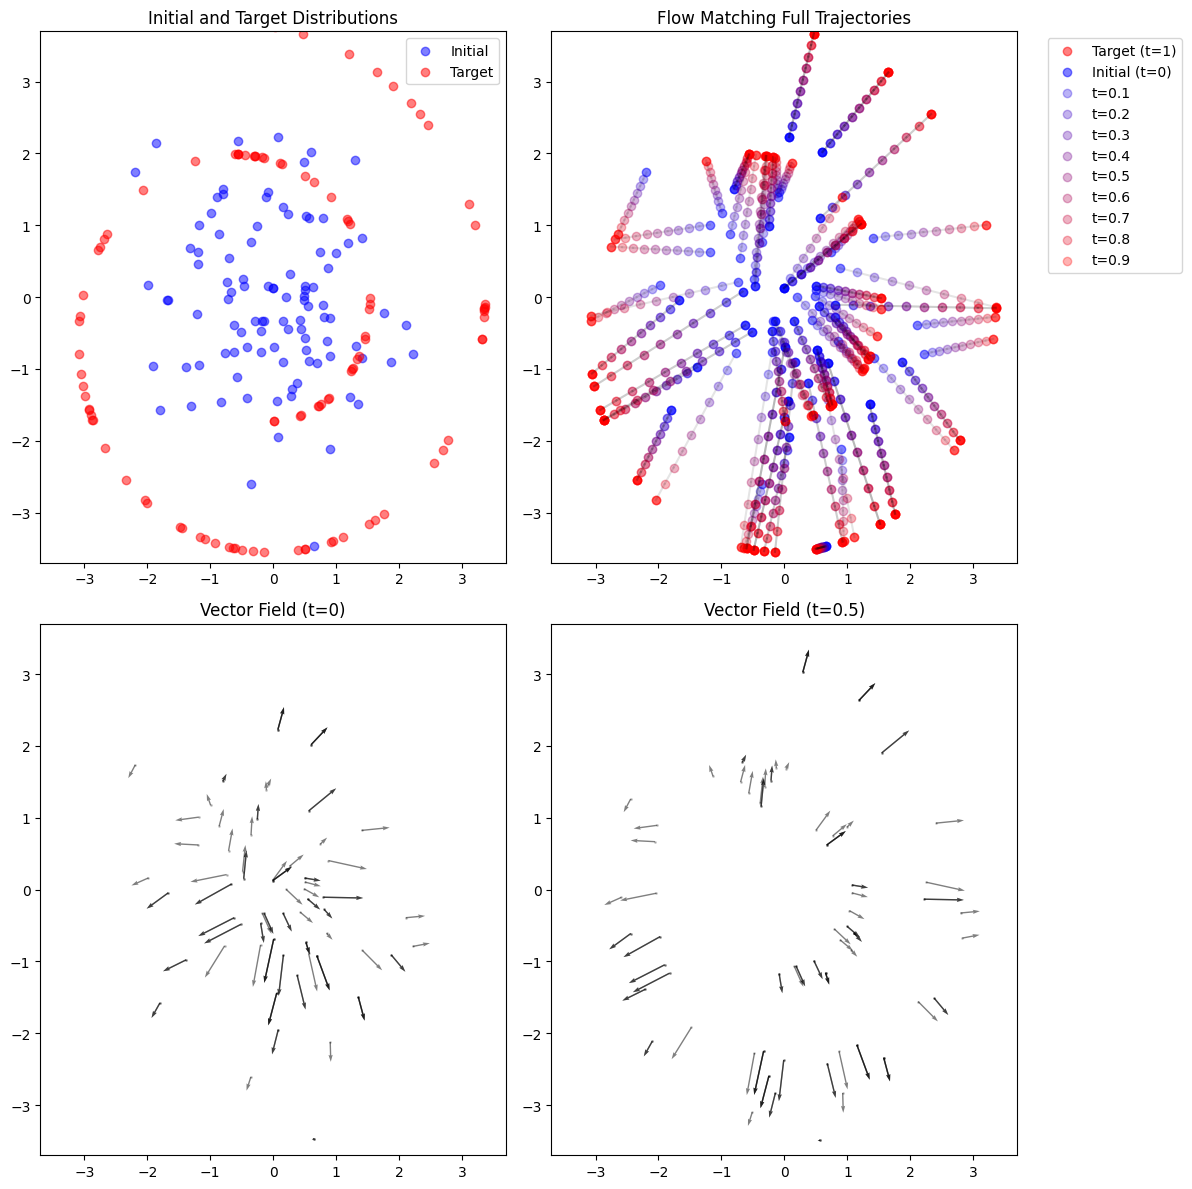

In [16]:
# This is the "teaching".
plot_flow_matching_trajectories(ExactOptimalTransportConditionalFlowMatcher(), n_examples=100)

### Visualizing the denoising flow

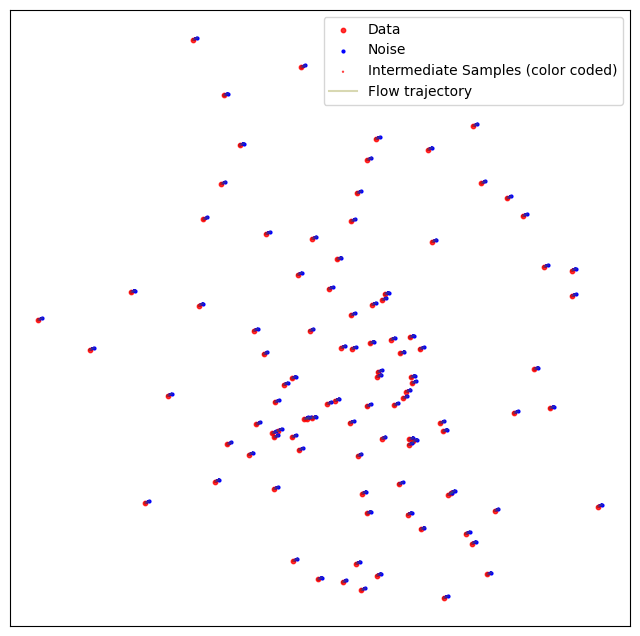

<Figure size 640x480 with 0 Axes>

In [17]:
from typing import Tuple


class TrajectorySet:
    def __init__(self, embeddings):
        """
        Managing a set of trajectories, each of which is a sequence of embeddings.

        Parameters
        ----------
        embeddings: (n_timesteps, n_samples, *embedding_dims). This assumes
            the first dimension is time. And it is ordered from t=0 to t=n_timesteps-1.
            With t=0 representing the clean data and t=n_timesteps-1 representing the noise.

        """
        self.embeddings = embeddings
        self.embeddings_2d = None
    
    def run_tsne(self, n_components: int = 2, seed: int = 0, **kwargs):
        """Run t-SNE on the embeddings.
        """
        print(f"Running t-SNE on {self.embeddings.shape} embeddings...")
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=n_components, random_state=seed, **kwargs)
        flattened_embeddings = self.embeddings.reshape(-1, self.embeddings.shape[-1])
        flattened_embeddings_2d = tsne.fit_transform(flattened_embeddings)
        self.embeddings_2d = flattened_embeddings_2d.reshape(self.embeddings.shape[0], self.embeddings.shape[1], -1)
        print(f"t-SNE done. Shape of 2D embeddings: {self.embeddings_2d.shape}")
        return self.embeddings_2d
    
    def plot_trajectories(
            self,
            n: int = 10,
            show_figure: bool = False,
            noise_color: Tuple[float, float, float] = (0, 0, 1),  # blue
            data_color: Tuple[float, float, float] = (1, 0, 0),  # red
            figsize: tuple = (6, 6),
            xlim: Tuple[float, float] = None,
            ylim: Tuple[float, float] = None,
            with_ticks: bool = False,
            title: str = None,
            tsne_seed: int = 0,
            **kwargs):
        """Plot trajectories of some selected samples.

        This assumes the first dimension is time. And it is ordered from t=0 to t=n_timesteps-1.
        With t=0 representing the clean data and t=n_timesteps-1 representing the noise.

        Parameters
        ----------
        n: int
            number of samples to plot
        figsize: tuple
            figure size
        kwargs:
            other keyword arguments for matplotlib.pyplot.scatter
        """
        import numpy as np
        import matplotlib.pyplot as plt

        colors = []
        for t in range(self.embeddings.shape[0]):
            # interpolate between noise_color and data_color
            factor = t / (self.embeddings.shape[0] - 1)
            colors.append(np.array(noise_color) * factor + np.array(data_color) * (1 - factor))
        colors = np.array(colors)
        
        if self.embeddings_2d is None:
            if self.embeddings.shape[2] == 2:
                self.embeddings_2d = self.embeddings
            else:
                self.embeddings_2d = self.run_tsne(seed=tsne_seed)

        traj = self.embeddings_2d[:, :n, :]
        g = plt.figure(figsize=figsize)
        plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="red")  # real
        plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")  # noise
        plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.5, alpha=0.7, c=colors.repeat(n, axis=0))  # "olive"
        plt.plot(traj[:, :n, 0], traj[:, :n, 1], c="olive", alpha=0.3)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.legend(["Data", "Noise", "Intermediate Samples (color coded)", "Flow trajectory"], loc="upper right")
        if not with_ticks:
            plt.xticks([])
            plt.yticks([])
        elif xlim is not None and ylim is not None:
            plt.xticks(xlim)
            plt.yticks(ylim)
        if title is not None:
            plt.title(title)
        if show_figure:
            plt.show()
        
        plt.tight_layout()
        # save to bytes (png)
        import io

        bytes_io = io.BytesIO()
        g.savefig(bytes_io, format="png")
        return bytes_io.getvalue()
        
        # # return the figure
        # return plt.gcf()

def generate_trajectories_from_denoising_model(model, num_samples=100, num_timesteps=100, data_dims=[2,], seed=0, device=device):
    node = NeuralODE(model, solver="euler", sensitivity="adjoint")
    torch.manual_seed(seed)
    with torch.no_grad():
        traj = node.trajectory(
            torch.randn(num_samples, *data_dims, device=device),
            t_span=torch.linspace(0, 1, num_timesteps, device=device),
        )
    traj = traj.cpu().numpy()
    # invert the time dimension to make it start from clean data to noise
    traj = traj[::-1, ...]
    traj_set = TrajectorySet(traj)
    return traj_set


def visualize_denoising_flow(model, n=100, seed=0):
    traj_set = generate_trajectories_from_denoising_model(model, num_samples=n, seed=seed)
    traj_set.plot_trajectories(n=n, show_figure=True, figsize=(8, 8))


# This is the "learning".
visualize_denoising_flow(model3, n=100)

In [18]:
# A shared state to store the frames for the vector field animation.
_state = {
    "frames": {},
}

def visualize_denoising_vector_field(model, t=0, num_samples=32, num_timesteps=100, seed=0):
    # visualize the vector field of the denoising model
    # The denoising model is a velocity field.
    # Given a grid of points, we can visualize the vector field at these points.
    x_grid = torch.linspace(-3.6, 3.6, 20)
    y_grid = torch.linspace(-3.6, 3.6, 20)
    x_grid, y_grid = torch.meshgrid(x_grid, y_grid)
    points = torch.stack([x_grid, y_grid], dim=-1)
    points = points.view(-1, 2).to(device)
    t_int = int(t * num_timesteps)
    t = t * torch.ones(points.shape[0]).to(device)
    with torch.no_grad():
        v = model(t=t, x=points)
        v = v.cpu().numpy()
    # plot the vector field
    points = points.cpu().numpy()
    x_grid = x_grid.cpu().numpy()
    y_grid = y_grid.cpu().numpy()

    if "traj" not in _state:
        node = NeuralODE(model, solver="euler", sensitivity="adjoint")
        data_dims = [2,]
        torch.manual_seed(seed)
        with torch.no_grad():
            _state["traj"] = node.trajectory(
                torch.randn(num_samples, *data_dims, device=device),
                t_span=torch.linspace(0, 1, num_timesteps, device=device),
            ).cpu().numpy()
    
    traj = _state["traj"]
    g = plt.figure(figsize=(6, 6))
    plt.quiver(x_grid, y_grid, v[:, 0], v[:, 1], alpha=0.5, scale=30, width=0.003)
    plt.scatter(points[:, 0], points[:, 1], c='k', alpha=0.2, s=1)
    # overlay with the points at the current timestep
    plt.scatter(traj[t_int, :, 0], traj[t_int, :, 1], c='blue', edgecolor='gray', alpha=0.5, s=25)
    plt.title(f"t={t_int}")
    plt.show()
    
    # save the figure into a numpy array
    # g = plt.gcf()
    # save figure as an image
    import io
    bytes_io = io.BytesIO()
    g.savefig(fname=bytes_io, format="png")
    _state["frames"][t_int] = bytes_io.getvalue()
    # return g


# create an interactive widget to visualize the vector field at different timesteps
from ipywidgets import interact, fixed

interact(visualize_denoising_vector_field, model=fixed(model3), t=(0.0, 0.99, 0.01), num_samples=fixed(100), num_timesteps=fixed(100), seed=fixed(0))



interactive(children=(FloatSlider(value=0.0, description='t', max=0.99, step=0.01), Output()), _dom_classes=('…

<function __main__.visualize_denoising_vector_field(model, t=0, num_samples=32, num_timesteps=100, seed=0)>

In [19]:
# Generate a GIF from the frames
from PIL import Image
import io
# _state["frames"] has bytes objects (png images)
frames = list(_state["frames"].values())
frames = [Image.open(io.BytesIO(frame)).resize((360, 360)) for frame in frames]
frames[0].save("initial_denoising_vector_field.gif", save_all=True, append_images=frames[1:], duration=500, loop=0)


# Training

Now that we have our data and models defined, we are ready for training.

Diffusion models have two key phases: Forward Diffusion and Reverse Denoising. 



## Training code

We've picked our data, created our dataloaders, and defined our noise schedule, foward diffusion, and reverse diffusion steps. Now, the only thing left to do is to train our diffusion model.

In [20]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, steps: int=100, quiet: bool=False) -> float:
  model.train()
  if not quiet:
    print("Training on device:", device)
  max_train_steps = steps

  step = 0
  loss = None
  while step < max_train_steps:

    if quiet:
      progress_bar = train_dataloader
    else:
      progress_bar = tqdm(train_dataloader, total=min(max_train_steps - step, len(train_dataloader)))
    for x_1 in progress_bar:
      optimizer.zero_grad()
      x_1 = x_1.float().to(device)

      x_0 = torch.randn_like(x_1).to(device)
      t, x_t, u_t = FM.sample_location_and_conditional_flow(x_0, x_1)

      v_t = model(t=t, x=x_t)
      v_t = v_t.sample if hasattr(v_t, "sample") else v_t
      loss = torch.mean((v_t - u_t) ** 2)  # MSE loss
      loss.backward()
      optimizer.step()

      if not quiet:
        progress_bar.set_postfix({"loss": loss.cpu().item()})

      step += 1

      if step >= max_train_steps:
        if not quiet:
          print(f"Reached the max training steps:", max_train_steps)
        break

  return loss

# Define the model and optimizer
model3 = Model3(
    dim_in=2,
    dim_out=2,
    dim_hids=[128, 128, 128],  # [128, 128, 256],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")
model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

# Train the model
model3_loss = train(model3, model3_optimizer, steps=1000)

model params: 182410
Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

Reached the max training steps: 1000


# Generation

We trained a model for 100 training steps. Let's see what the output looks like at this early stage.

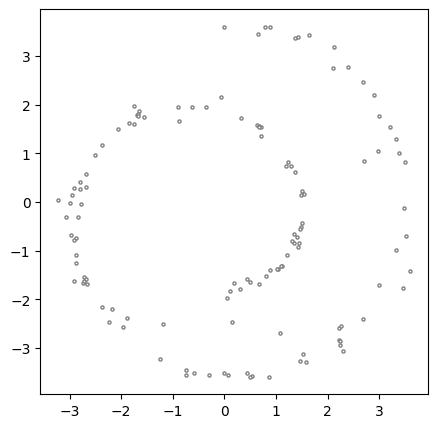

In [21]:
# visualize the sampled images
def visualize_sampled_data(model):
  # print("Loss of the denoising model:", loss.item())
  x_sampled = generate_samples_with_flow_matching(
    denoising_model=model,
    device=device,
    num_samples=128,
    parallel=False,
    seed=0,
    clip_min=-3.6,
    clip_max=3.6,
  )

  # plt.scatter(x_sampled[:, 0], x_sampled[:, 1])
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))
  x_sampled = x_sampled.cpu().numpy()
  axs.scatter(x_sampled[:,0], x_sampled[:,1], color='white', edgecolor='gray', s=5)
  # axs.set_axis_off()
  # plt.xlim(-3.6, 3.6)
  # plt.ylim(-3.6, 3.6)
  return fig

model3.eval()
_ = visualize_sampled_data(model3)

We can already see a spiral starting to form. What if we increase the length of training?

Training on device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 2.828742504119873


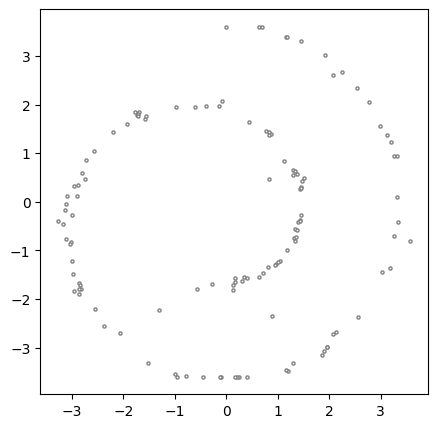

In [22]:
# Train some more
model3_loss = train(model3, model3_optimizer, steps=1000)
print("loss:", model3_loss.item())
_ = visualize_sampled_data(model3)

That's more like it! In just 1000 training steps, we were able to go from complete noise to a fairly representative spiral.



What does the denoising flow look like?

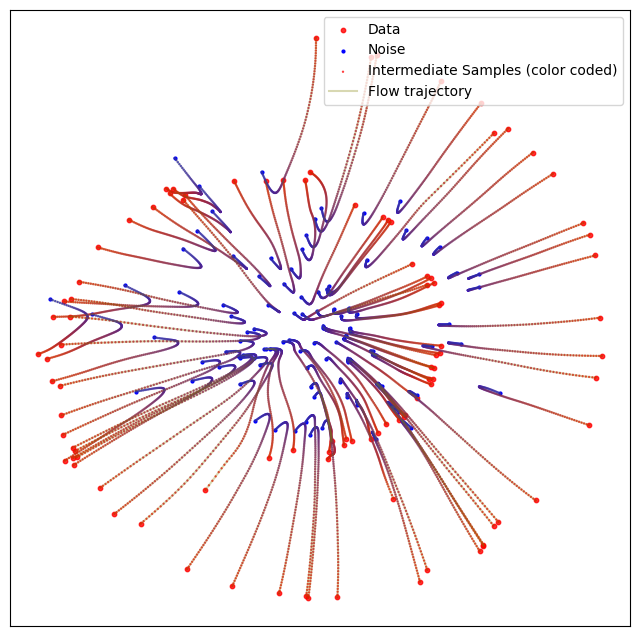

<Figure size 640x480 with 0 Axes>

In [23]:

visualize_denoising_flow(model3)


### Visualize the learned vector field over time

In [24]:
# A shared state to store the frames for the vector field animation.
_state = {
    "frames": {},
}

interact(visualize_denoising_vector_field, model=fixed(model3), t=(0.0, 0.99, 0.01), num_samples=fixed(128), num_timesteps=fixed(100), seed=fixed(0))

interactive(children=(FloatSlider(value=0.0, description='t', max=0.99, step=0.01), Output()), _dom_classes=('…

<function __main__.visualize_denoising_vector_field(model, t=0, num_samples=32, num_timesteps=100, seed=0)>

In [25]:
# save the frames as a GIF
if _state["frames"]:
    frames = list(_state["frames"].values())
    frames = [Image.open(io.BytesIO(frame)).resize((360, 360)) for frame in frames]
    frames[0].save(
        "learned_denoising_vector_field.gif", save_all=True,
        append_images=frames[1:],
        duration=100 * 5,  # Increased duration (milliseconds per frame) for slower motion
        loop=0
    )


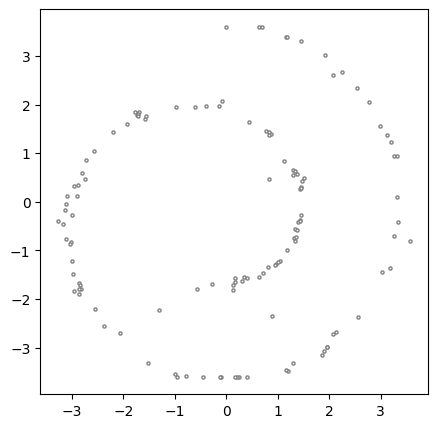

In [26]:
_ = visualize_sampled_data(model3)

### Learned denoising flow over time

To get a better idea of what the inbetween steps looked like, let's animate the process every 100 steps.

In [27]:
model3 = Model3(
    dim_in=2,
    dim_out=2,
    dim_hids=[128, 128, 256],
    num_timesteps=config.num_denoising_steps,
).to(device)
model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

samples = []
num_samples = 10
all_trajs = []
steps_to_checkpoint = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 300, 400, 500]
for i, checkpoint_steps in tqdm(enumerate(steps_to_checkpoint), total=len(steps_to_checkpoint)):
    steps = checkpoint_steps - steps_to_checkpoint[i-1] if i > 0 else checkpoint_steps
    model3_loss = train(model3, model3_optimizer, steps=steps, quiet=True)
    node = NeuralODE(model3, solver="euler", sensitivity="adjoint")
    torch.manual_seed(0)
    num_samples = 100
    num_timesteps = 100
    data_dims = [2,]
    # clip_min = -3.6
    # clip_max = 3.6
    with torch.no_grad():
        torch.manual_seed(0)
        trajs = node.trajectory(
            torch.randn(num_samples, *data_dims, device=device),
            t_span=torch.linspace(0, 1, num_timesteps, device=device),
        )
        trajs = trajs.cpu().numpy()
        # invert the time dimension to make it start from clean data to noise
        trajs = trajs[::-1, ...]
        # all_trajs.append(trajs)
        # plot the trajectory
        traj_set = TrajectorySet(trajs)
        all_trajs.append(traj_set)
    # samples.append(generate_samples_with_flow_matching(model3, device, num_samples=128, parallel=False, seed=0, clip_min=-3.6, clip_max=3.6))


  0%|          | 0/22 [00:00<?, ?it/s]

In [28]:
# A shared state to store the frames for the vector field animation.
_state = {
    "frames": {},
}

def show_traj_at_learning_step(i=0):
    bytes_value = all_trajs[i].plot_trajectories(
        n=100, show_figure=True, figsize=(6, 6),
        with_ticks=True, title=f"train steps = {steps_to_checkpoint[i]}",
        xlim=(-5, 5), ylim=(-5, 5),
    )
    _state["frames"][steps_to_checkpoint[i]] = bytes_value

interact(show_traj_at_learning_step, i=(0, len(all_trajs)-1, 1))

interactive(children=(IntSlider(value=0, description='i', max=21), Output()), _dom_classes=('widget-interact',…

<function __main__.show_traj_at_learning_step(i=0)>

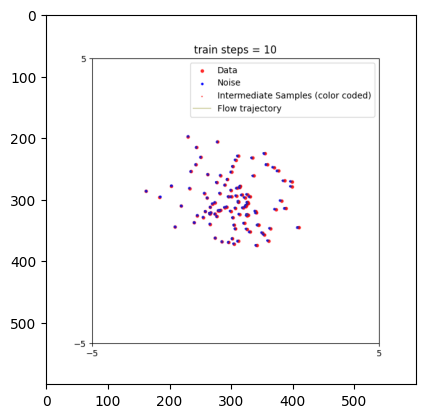

In [29]:
# save the frames as a GIF
if _state["frames"]:
    frames = list(_state["frames"].values())
    frames = [Image.open(io.BytesIO(frame)) for frame in frames]
    # Add copies of the last frame to make it pause at the end
    frames_with_pause = frames[:-1] + [frames[-1]] * 5
    frames[0].save(
        "denoising_trajectories_over_training_steps.gif", save_all=True,
        append_images=frames_with_pause[1:],
        duration=100 * 5,  # Increased duration (milliseconds per frame) for slower motion
        loop=0
    )
    plt.imshow(frames[0])  # double check that the first frame looks ok


# Comparing Model Performance

To compare the quality of different model architectures at generating 2D spirals, we can use the Chamfer distance. The Chamfer distance is an evaluation metric for comparing two point clouds, so it's perfect for our data.

In [30]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def chamfer_distance(x, y, metric='l2', direction='bi'):
    """Chamfer distance between two point clouds

    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
        first point cloud
    y: numpy array [n_points_y, n_dims]
        second point cloud
    metric: string or callable, default 'l2'
        metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
    direction: str
        direction of Chamfer distance.
            'y_to_x':  computes average minimal distance from every point in y to x
            'x_to_y':  computes average minimal distance from every point in x to y
            'bi': compute both
    Returns
    -------
    chamfer_dist: float
        computed bidirectional Chamfer distance:
            sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
    """
    
    if direction=='y_to_x':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        chamfer_dist = np.mean(min_y_to_x)
    elif direction=='x_to_y':
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_x_to_y)
    elif direction=='bi':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)
    else:
        raise ValueError("Invalid direction type. Supported types: \'y_x\', \'x_y\', \'bi\'")
        
    return chamfer_dist

## Model 1

model params: 265730
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Reached the max training steps: 10000
model1_loss: 4.076655387878418


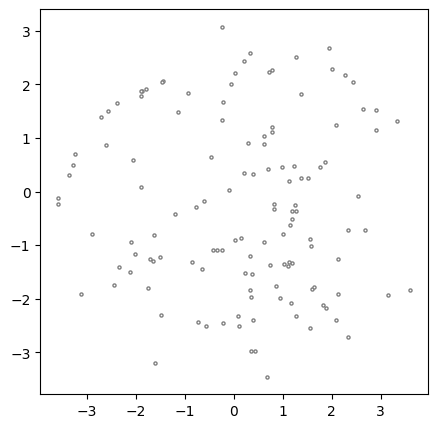

In [31]:
model1 = Model1().to(device)
print(f"model params: {sum(p.numel() for p in model1.parameters())}")

model1_optimizer = optim.AdamW(model1.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model1_loss = train(model1, model1_optimizer, steps=10000)
print("model1_loss:", model1_loss.item())
_ = visualize_sampled_data(model1)

## Model 2

model params: 207362
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Reached the max training steps: 10000
model2_loss: 2.588679552078247


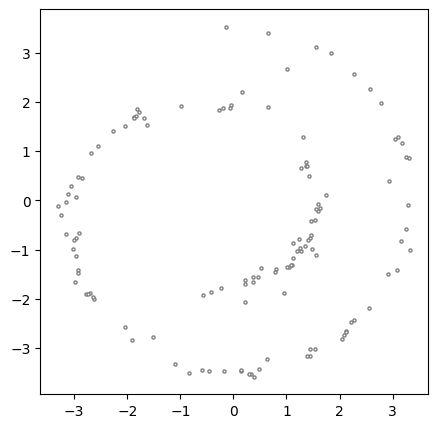

In [32]:
model2 = Model2(features=2, hidden_features=[256, 256, 512]).to(device)
print(f"model params: {sum(p.numel() for p in model2.parameters())}")

model2_optimizer = optim.AdamW(model2.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model2_loss = train(model2, model2_optimizer, steps=10000)
print("model2_loss:", model2_loss.item())
_ = visualize_sampled_data(model2)

## Model 3

model params: 182410
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Reached the max training steps: 10000
model3_loss: 2.8772902488708496


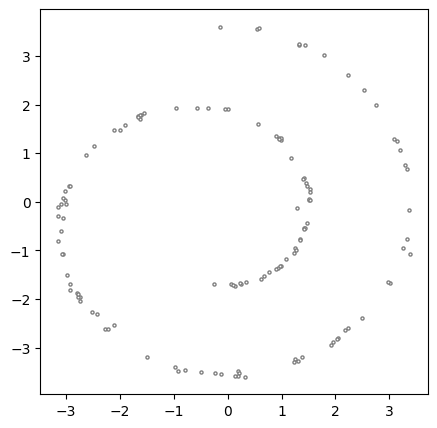

In [38]:
model3 = Model3(
    dim_in=2,
    dim_out=2,
    dim_hids=[128, 128, 128],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model3_loss = train(model3, model3_optimizer, steps=10000)
print("model3_loss:", model3_loss.item())
_ = visualize_sampled_data(model3)

Model 1 Chamfer Distance: 0.8956205309371118
Model 2 Chamfer Distance: 0.2796899852647907
Model 3 Chamfer Distance: 0.1814753063283065


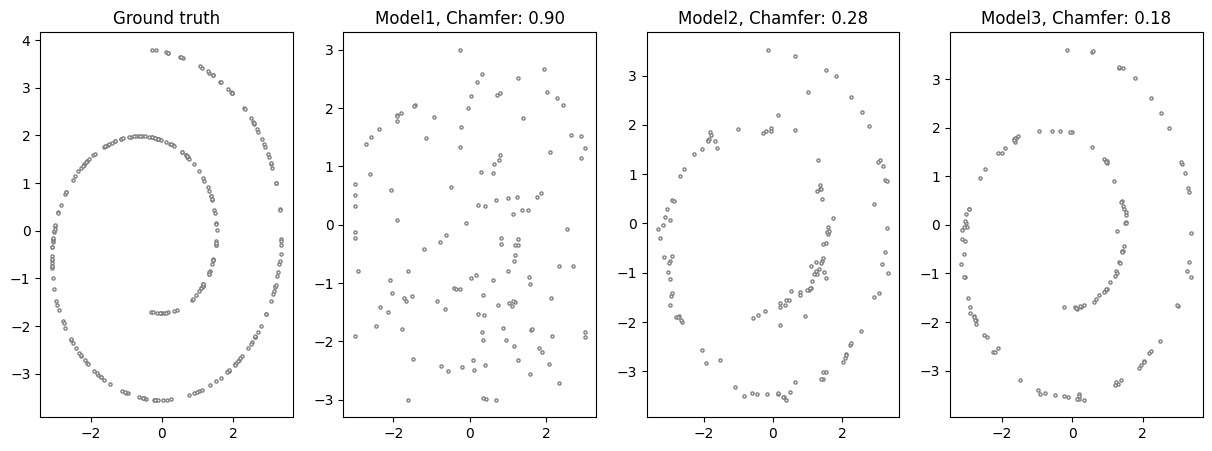

In [39]:
import torch

# Sample points from the model
def generate_points(model):
    with torch.no_grad():
        x_T = torch.randn(128, 2)
        x_sampled = generate_samples_with_flow_matching(model, device, num_samples=128, parallel=False, seed=0, clip_min=-3.6, clip_max=3.6)
    return x_sampled.cpu().numpy()


# The target spiral points for comparison
target_spiral = next(iter(train_dataloader))
chamfer_dist = {}

generated_points_1 = generate_points(model1)
generated_points_1 = np.clip(generated_points_1, -3, 3)
chamfer_dist[1] = chamfer_distance(generated_points_1, target_spiral, direction='bi')
print("Model 1 Chamfer Distance:", chamfer_dist[1])


generated_points_2 = generate_points(model2)
chamfer_dist[2] = chamfer_distance(generated_points_2, target_spiral, direction='bi')
print("Model 2 Chamfer Distance:", chamfer_dist[2])

# Calculate Chamfer distance
generated_points_3 = generate_points(model3)
chamfer_dist[3] = chamfer_distance(generated_points_3, target_spiral, direction='bi')
print("Model 3 Chamfer Distance:", chamfer_dist[3])

# # visualize the sampled images side by side
def visualize_sampled_data_side_by_side(models, generated_points):
    fig, axs = plt.subplots(1, len(models) + 1, figsize=(5 * len(models), 5))
    # Add ground truth
    axs[0].scatter(target_spiral[:, 0], target_spiral[:, 1], color='white', edgecolor='gray', s=5)
    axs[0].set_title("Ground truth")

    for i, (model, points) in enumerate(zip(models, generated_points)):
        axs[i+1].scatter(points[:,0], points[:,1], color='white', edgecolor='gray', s=5)
        axs[i+1].set_title(f"{model.__class__.__name__}, Chamfer: {chamfer_dist[i+1]:.2f}")

visualize_sampled_data_side_by_side([model1, model2, model3], [generated_points_1, generated_points_2, generated_points_3])

Visually and quantitatively, Model 3 and Model 2 outpeform Model 1 a large margin. Model 3 is also clearly better than Model 2.

Try experimenting with the hidden layer configuration and the number of timesteps. You should be able to get all the models to produce perfect spirals by simply increasing the number of parameters or increasing the number of timesteps.

## Questions for future exploration

- How does the model size matter (number of parameters, controlled by the number of layers, and number of hidden units), within the same class of arch?
- How does the number of timesteps matter?
- What other designs of flow plans are there in recent literature? Can you bring them to this toy example?
